### 爬取数据(如果无法成功可能是IP被禁了)
* 爬取电影《飞驰人生》评论数据
* 将其存储于pacong.csv文件中

In [2]:
import csv
import time
import requests
import warnings
import numpy as np
from bs4 import BeautifulSoup
# 过滤没必要的警告信息
warnings.filterwarnings('ignore')

def get_html_text(url):
    try:
        headers = {
            'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:74.0) Gecko/20100101 Firefox/74.0',
            'Connection': 'close'
        }
        html = requests.get(url,headers = headers,verify=False).text
        return html
    except:
        time.sleep(1)
        return "error"

def solve_and_save(url,writer):
    # 如return非html，则不断请求
    while True:
        html = get_html_text(url)
        if html != 'error':
            break
    soup = BeautifulSoup(html,'html.parser')
    review_list = soup.find('div','review-list')
    
    for div in review_list.div.find_next_siblings()[0:-1]:
        div = div('div')[0]
        header = div('header')[0]
        main_body = div('div')[0]
        name = header('a')[1].string
        stars = header('span')[0].get('title')
        if len(header('span'))==1:
            time = 'no star'
        else:
            time = header('span')[1].string

#         find main body usefful
        title = main_body('h2')[0]('a')[0].string
        content = main_body.find('div','short-content').string
        action = main_body.find('div','action')
        userful_nums = str(action('a')[0]('span')[0].string).replace(' ','')
        useless_nums = str(action('a')[1]('span')[0].string.replace(' ',''))
        reply_nums = str(action('a')[2].string.replace(' ',''))
    
        data = [(name,stars,time,title,content,userful_nums,useless_nums,reply_nums)]
        writer.writerows(data)  # 多行用writerows

def main():
    csv_path = 'pacong.csv'
    page_review_numbers = 20
    page = 100
    # 将爬虫爬下来的数据，放入如下文件内; 如果不指定newline='',有时则每写入一行将有一空行被写入
    csvfile = open(csv_path, 'w',newline='',encoding='utf-8')
    writer = csv.writer(csvfile)
    writer.writerow(['评论人姓名', '评价', '评论时间','评论标题','评论主体','赞成数','反对数','回复数']) # 写入一行用writerow
    start = time.time()
    for i in range(0,page*page_review_numbers,page_review_numbers):
        time.sleep(0.5)
        url = 'https://movie.douban.com/subject/30163509/reviews?start='+str(i)
        solve_and_save(url,writer)
        print (f'Have already get the {i+20}th reviews')
    end = time.time()
    print (f'The whole process use {(end - start)/60} minutes')
    csvfile.close()
    
main()

Have already get the 20th reviews


AttributeError: 'NoneType' object has no attribute 'div'

### 加载数据&生成图云

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\刘志远\AppData\Local\Temp\jieba.cache
Loading model cost 1.148 seconds.
Prefix dict has been built successfully.


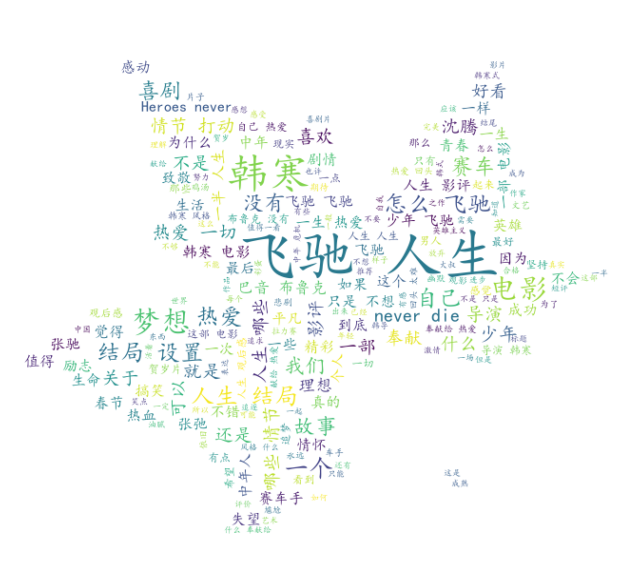

In [1]:
import os
import warnings
import jieba
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# 过滤没必要的警告信息
warnings.filterwarnings('ignore')

# 加载词云背景图片路径,枫叶形状
ciyun_path = 'ciyun.jpeg'
# 词云字体路径,这里用的是楷体。  -----》可至 C:\Windows\Fonts 中下载字体
ciyunfont_path = 'simkai.ttf'
# 加载数据路径
data_path = 'pacong.csv'
# 结果图片路径
result_path = 'result_images'

background_image = cv.imread(ciyun_path)
data = pd.read_csv(data_path)
all_content = ''
for i in range(0,len(data['评论标题'])):
    all_content= all_content+data['评论标题'][i]
cut_text = " ".join(jieba.cut(all_content))

wordcloud = WordCloud(font_path=ciyunfont_path,mask=background_image,background_color='white').generate(cut_text)
plt.figure(figsize=(8,8))
if not os.path.exists(result_path):
    os.makedirs(result_path)
# 保存生成图片
plt.savefig(f'{result_path}/ciyun.png')
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

### 数据处理（清洗）
Funtion：
* 将从网站上爬虫下来的数据，处理为规范数据
* 便于后续使用numpy与pandas处理数据

Tips：
* 该代码块请勿重复运行，重复处理数据会报错。一遍即可
* 如果需要重复运行，报错。请restart内核或清除运行内存

In [2]:
# 将评价中的文字（力荐、推荐等），转化为int值
def prepressingData(data1):
    data = data1.copy()
    zancheng = data['赞成数']
    fandui = data['反对数']
    huifu = data['回复数']
    pingjia = data['评价']
    star = []
    for i in range(0,len(zancheng)):
        zancheng[i] = zancheng[i].replace('\n','')
        fandui[i] = fandui[i].replace('\n','')
        huifu[i] = huifu[i].replace('回应',' ')
        if pingjia[i]=='力荐':
            star.append(5)
        elif pingjia[i]=='推荐':
            star.append(4)
        elif pingjia[i]=='还行':
            star.append(3)
        elif pingjia[i]=='较差':
            star.append(2)
        elif pingjia[i]=='很差':
            star.append(1)
        else:
            star.append(0)
    data['评价得分'] = pd.Series(star)
    data = data.drop(axis=1,columns=['评论主体'])
#     删除列，后要赋值过去才算成功
    return data

# 将string类型的数量---》int类型的数量
def cvtInt(data1):
    data = data1.copy()
    data['赞成数'] = pd.to_numeric(data['赞成数'],errors='ignore')
    data['赞成数'] = data['赞成数'].fillna(0)
    data['反对数'] = pd.to_numeric(data['反对数'],errors='ignore')
    data['反对数'] = data['反对数'].fillna(0)
    data['回复数'] = pd.to_numeric(data['回复数'],errors='ignore')
    return data

# 扔掉一些没用的数据
def dropUselessTime(data):
    data1 = data.copy()
    index = data1[data1['评论时间']=='no star'].index
    data1 = data1.drop(axis=0,index=index)
    return data1

data = prepressingData(data)
data = cvtInt(data)
data = dropUselessTime(data)
data.index = data['评论时间']

### 统计评分情况

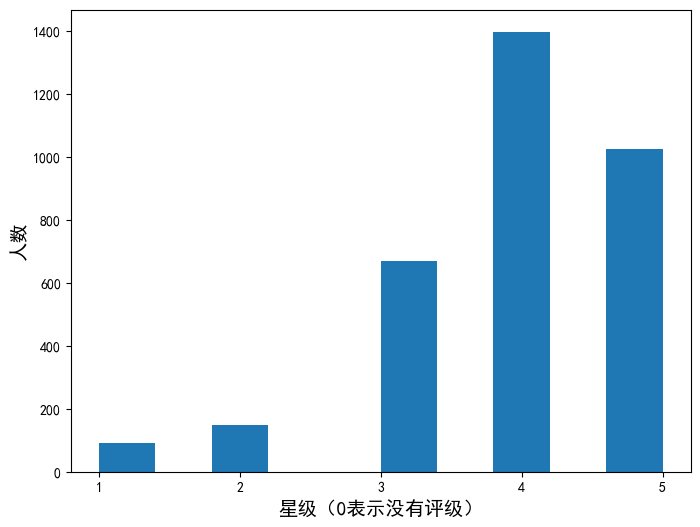

In [11]:
# 画图开始,设置黑体字体
plt.rcParams['font.sans-serif']=['SimHei']
plt.figure(figsize=(8,6))
plt.hist(data['评价得分'],bins=10)
plt.xticks([i+1 for i in range(5)])
plt.xlabel('星级（0表示没有评级）',size=14)
plt.ylabel('人数',size=14)
plt.savefig(f'{result_path}/xingji.png')
plt.show()

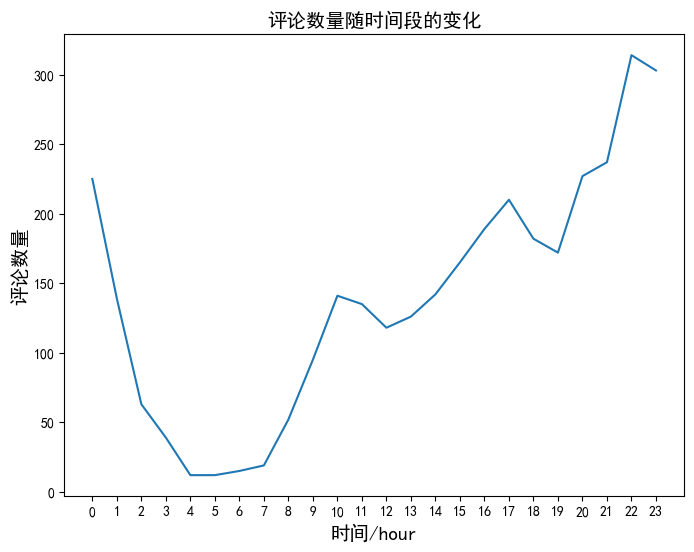

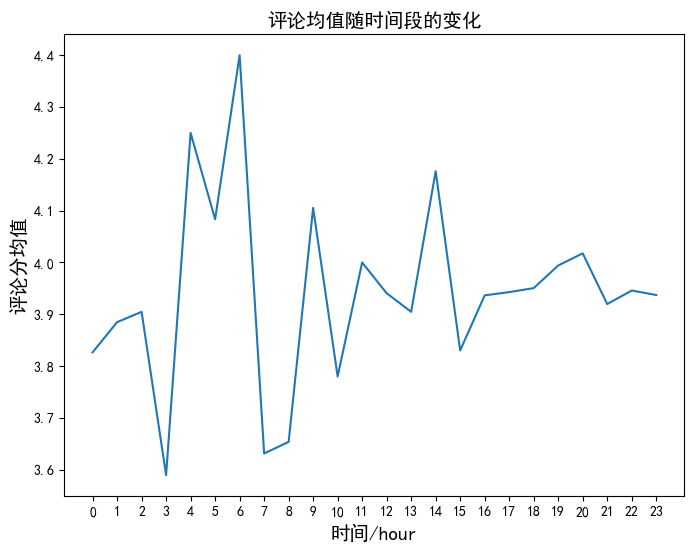

In [16]:
data['month'] = pd.to_datetime(data['评论时间']).dt.month
data['hour'] = pd.to_datetime(data['评论时间']).dt.hour
def plotTimeWithData(data):
    data1 = data.copy()
    cur = data1.groupby('hour').count()
    plt.figure(figsize=(8,6))
    plt.plot(cur.index,cur['month'])
    plt.xlabel('时间/hour',size=14)
    plt.ylabel('评论数量',size=14)
    plt.title('评论数量随时间段的变化',size=14)
    xticks=list(range(0,len(cur.index))) # 这里设置的是x轴点的位置
    plt.xticks(xticks)
    plt.savefig(f'{result_path}/review_count.png')
    plt.show()
    
    cur = data1.groupby('hour').mean()
    plt.figure(figsize=(8,6))
    plt.plot(cur.index,cur['评价得分'])
    plt.xlabel('时间/hour',size=14)
    plt.ylabel('评论分均值',size=14)
    plt.title('评论均值随时间段的变化',size=14)
    xticks=list(range(0,len(cur.index))) # 这里设置的是x轴点的位置
    plt.xticks(xticks)
    plt.savefig(f'{result_path}/review_mean.png')
    plt.show()
    
plotTimeWithData(data)